# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import math

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

from importlib import reload
import HW_7
reload(HW_7)
from HW_7 import Server, Client, generate_matrix

In [112]:
n = 10
clients = []
L = 1000
mu = 1
d = 100
for i in range(n):
    np.random.seed(i)
    clients.append(Client(d, generate_matrix(d, mu, L), np.random.randn(d) * L - L/2))
server = Server(d=d, clients=clients)

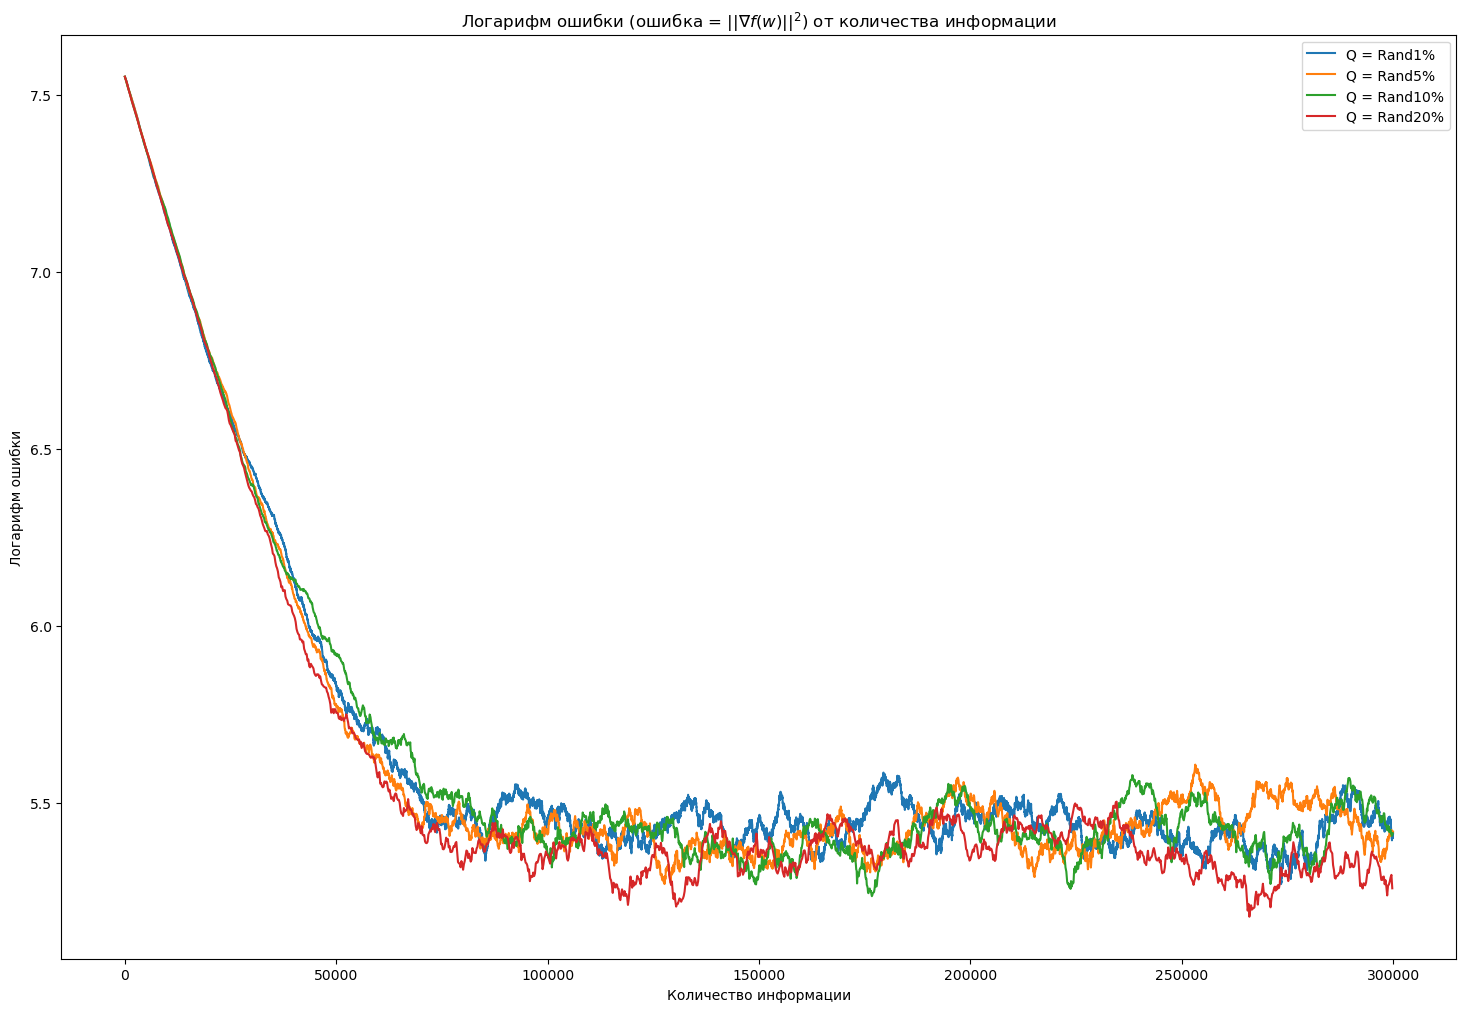

In [113]:
iter = 1500

plt.figure(figsize=(18, 12))
server.set_func("quad")
Q_operators = ["Rand1%", "Rand5%", "Rand10%", "Rand20%"]
iter_operators = [iter*20, iter*4, iter*2, iter]
gamma = 0.1 / L
for oper, iter_ in zip(Q_operators, iter_operators):
    server.set_Q_operator(oper)
    server.GD(iter_, gamma)
    
    x_GD, y_GD = server.get_info_converge()
    plt.plot(x_GD, np.log10(y_GD), label=f'Q = {oper}')

plt.legend()
plt.title('Логарифм ошибки (ошибка = $||\\nabla f(w)||^2$) от количества информации')
plt.xlabel('Количество информации')
plt.ylabel('Логарифм ошибки')
None

## Вывод:
Разные операторы работают схоже при одинаковом количестве отправленной информации, но при меньшем количестве разово отправленной информации нужно будет сделать большее количество коммуникаций. Уменьшив шаг, метод начнется сходится медленее, также появляется порог сходимости, на котором метод останавливается из-за стохастичности. Увеличивая шаг, мы соотвественно увеличиваем этот порог.

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

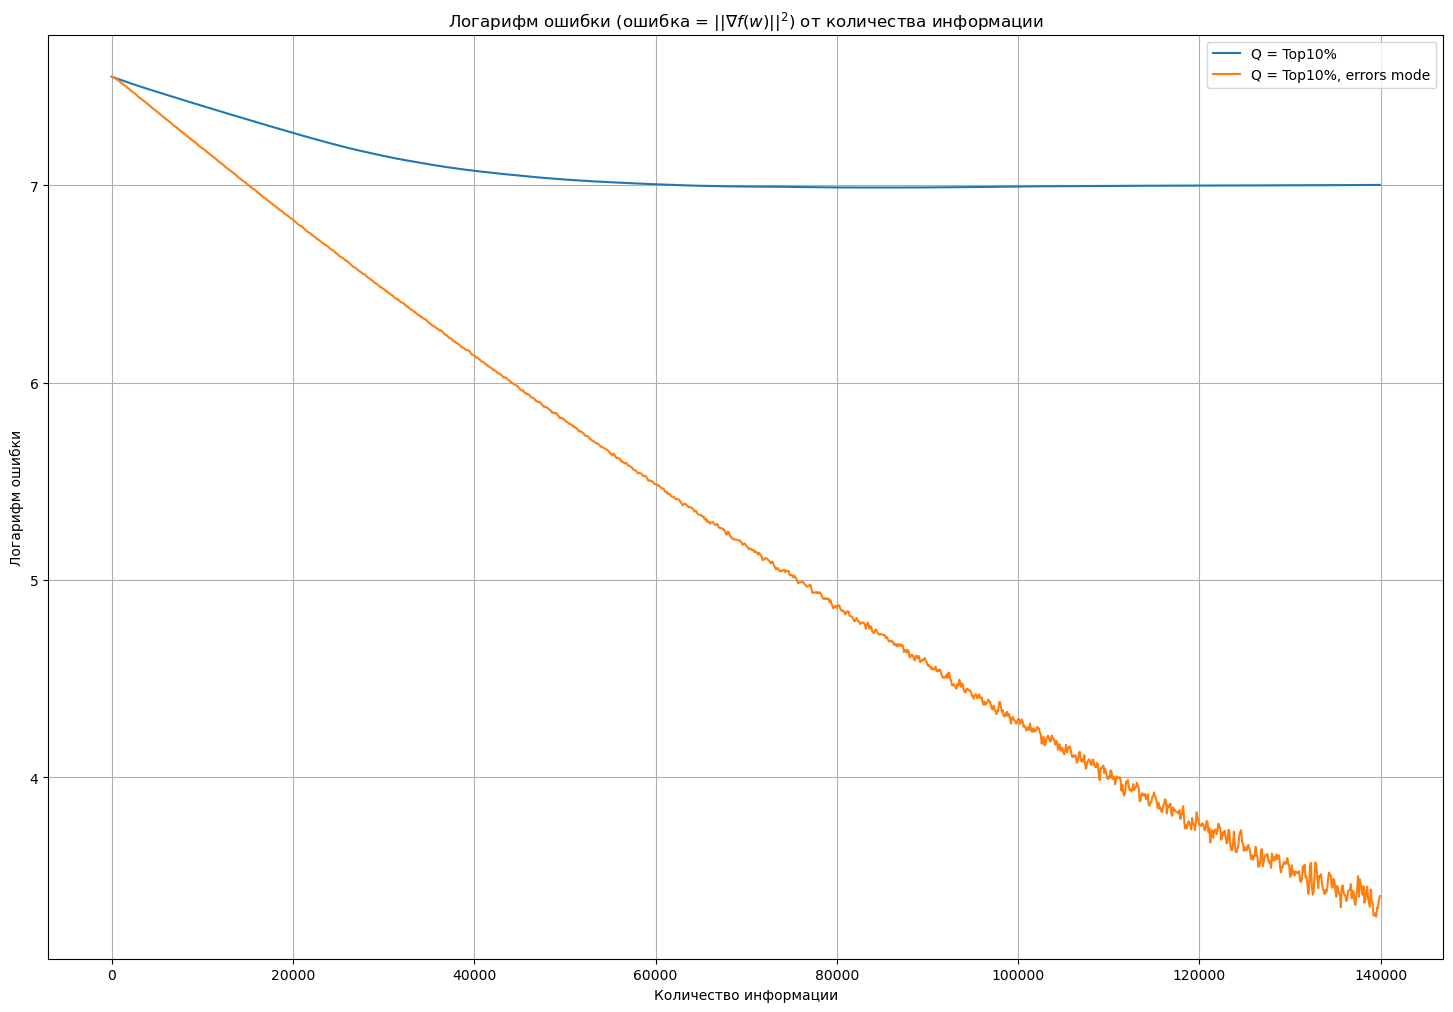

In [114]:
iter = 1400

plt.figure(figsize=(18, 12))

server.set_Q_operator('Top10%')

server.GD(iter, 0.01 / L)
x_gd, y_gd = server.get_info_converge()
plt.plot(x_gd, np.log10(y_gd), label=f'Q = {server.Q_operator}')

server.errors(iter, 3/L)
x_gd, y_gd = server.get_info_converge()
plt.plot(x_gd, np.log10(y_gd), label=f'Q = {server.Q_operator}, errors mode')

plt.legend()
plt.title('Логарифм ошибки (ошибка = $||\\nabla f(w)||^2$) от количества информации')
plt.grid()
plt.xlabel('Количество информации')
plt.ylabel('Логарифм ошибки')
None

## Вывод:
С помощью метода компенсации ошибки можно опустить порог, на котором останавливается сходимость алгоритма, при одинаковом количестве пересылок он работате напорядок лучше на квадратичной задачи.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [133]:
from datetime import datetime as dt
import random
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

from importlib import reload
import HW_7
reload(HW_7)
from HW_7 import Server, Client, generate_matrix, estimate_L_logistic

In [134]:
data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = y * 2 - 3
N, d = X.shape
L = estimate_L_logistic(X)
print("N = {}, d = {}".format(N, d))

N = 8124, d = 112


In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [136]:
n = 10
clients = []
n_per_client = y_train.size // n

for i in range(n):
    new_X = X_train[i * n_per_client : (i + 1) * n_per_client]
    new_y = y_train[i * n_per_client : (i + 1) * n_per_client]
    clients.append(Client(d, new_X, new_y))

server = Server(d, clients, X_test=X_test, y_test=y_test)

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

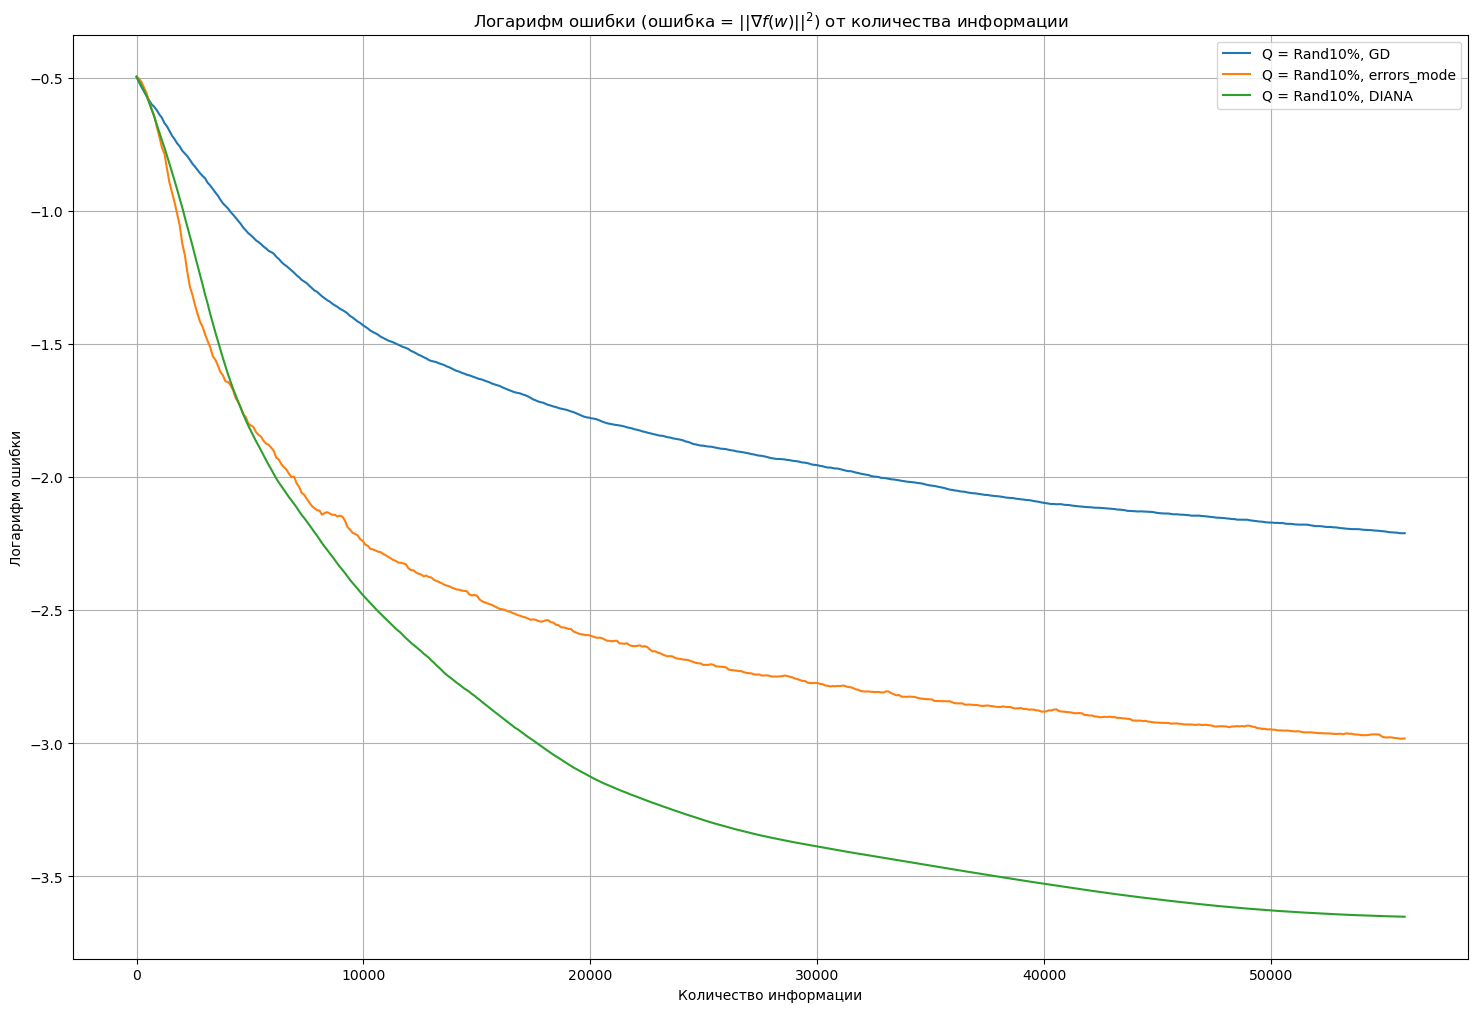

In [139]:
iter = 500

plt.figure(figsize=(18, 12))


server.set_Q_operator("Rand10%")
server.set_func("logistic")
server.lamb = L / 1000

server.GD(iter , 1 / L)
x_GD, y_GD = server.get_info_converge()
plt.plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, GD')

server.errors(iter, 1 / L)
x_GD, y_GD = server.get_info_converge()
plt.plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, errors_mode')

server.DIANA(iter, 1 / L, 0.1)
x_GD, y_GD = server.get_info_converge()
plt.plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, DIANA')

plt.legend()
plt.title('Логарифм ошибки (ошибка = $||\\nabla f(w)||^2$) от количества информации')
plt.grid()
plt.xlabel('Количество информации')
plt.ylabel('Логарифм ошибки')
None

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

Text(0, 0.5, 'Точность')

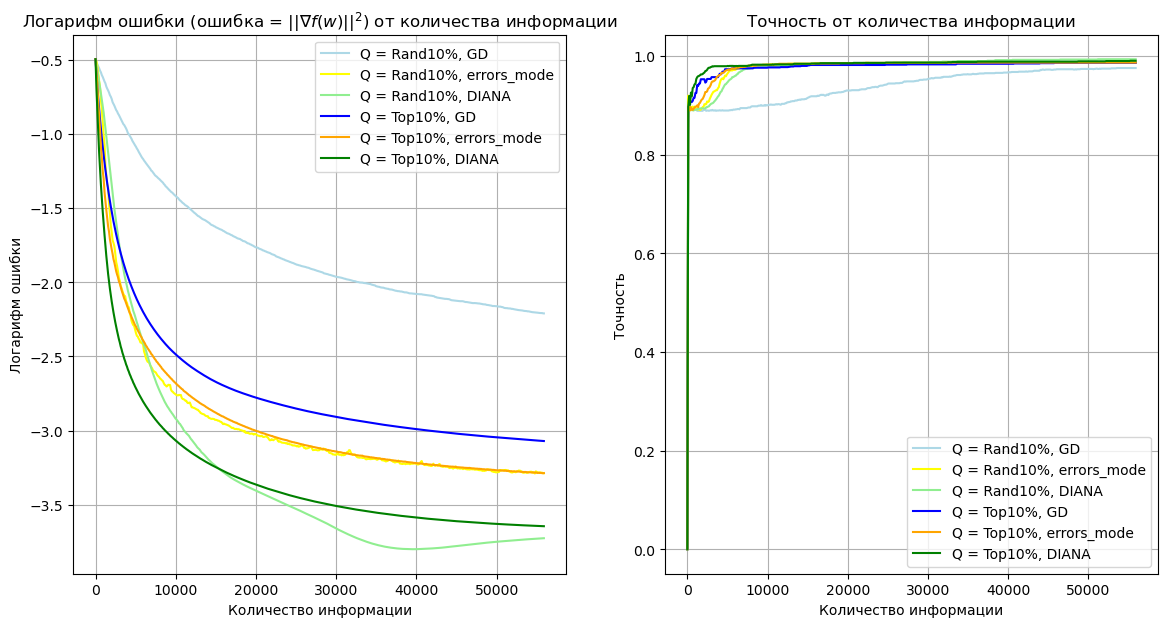

In [140]:
steps = 500

_, ax = plt.subplots(1, 2, figsize=(14, 7))

server.set_Q_operator("Rand10%")
server.set_func("logistic")
server.lamb = L / 1000


server.GD(steps, 1 / L)
x_GD, y_GD = server.get_info_converge()
ax[0].plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, GD', color="lightblue")
x_GD, y_GD = server.get_info_accuracies()
ax[1].plot(x_GD, y_GD, label=f'Q = {server.Q_operator}, GD', color="lightblue")

server.errors(steps, 1.5 / L)
x_GD, y_GD = server.get_info_converge()
ax[0].plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, errors_mode', color="yellow")
x_GD, y_GD = server.get_info_accuracies()
ax[1].plot(x_GD, y_GD, label=f'Q = {server.Q_operator}, errors_mode', color="yellow")

server.DIANA(steps, 2 / L, 0.1)
x_GD, y_GD = server.get_info_converge()
ax[0].plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, DIANA', color="lightgreen")
x_GD, y_GD = server.get_info_accuracies()
ax[1].plot(x_GD, y_GD, label=f'Q = {server.Q_operator}, DIANA', color="lightgreen")

server.set_Q_operator("Top10%")

server.GD(steps, 1 / L)
x_GD, y_GD = server.get_info_converge()
ax[0].plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, GD', color="blue")
x_GD, y_GD = server.get_info_accuracies()
ax[1].plot(x_GD, y_GD, label=f'Q = {server.Q_operator}, GD', color="blue")

server.errors(steps, 1.5 / L)
x_GD, y_GD = server.get_info_converge()
ax[0].plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, errors_mode', color="orange")
x_GD, y_GD = server.get_info_accuracies()
ax[1].plot(x_GD, y_GD, label=f'Q = {server.Q_operator}, errors_mode', color="orange")

server.DIANA(steps, 2 / L, 0.1)
x_GD, y_GD = server.get_info_converge()
ax[0].plot(x_GD, np.log10(y_GD), label=f'Q = {server.Q_operator}, DIANA', color="green")
x_GD, y_GD = server.get_info_accuracies()
ax[1].plot(x_GD, y_GD, label=f'Q = {server.Q_operator}, DIANA', color="green")

ax[0].legend()
ax[0].set_title('Логарифм ошибки (ошибка = $||\\nabla f(w)||^2$) от количества информации')
ax[0].grid()
ax[0].set_xlabel('Количество информации')
ax[0].set_ylabel('Логарифм ошибки')

ax[1].legend()
ax[1].set_title('Точность от количества информации')
ax[1].grid()
ax[1].set_xlabel('Количество информации')
ax[1].set_ylabel('Точность')

## Вывод:
Как видно из графиков, метод компенсации работает лучше градиентного спуска, но медленее, чем DIANA, это верно для разных операторов сжатия, также можно заметить, что 'Top%10' работает быстрее, чем 'Rand%10'.

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [ ]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#ответ